In [1]:
#-----import packages-----#

#common python packages
import numpy as np
import string
import random
import os
import pickle
import argparse
import wget
import math
import gc
import sys
import multiprocessing as mp

#biological packages
import pybedtools
from pybedtools import featurefuncs
import pyBigWig

#machine learning packages
import sklearn
from sklearn.utils import shuffle
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

%matplotlib inline

In [37]:
#load in original bed from prediction
file_dir = "/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/validation/Sutton/"
file_name = "H1.17k.enhancer.hg38.bed"
sutton_bed = pybedtools.BedTool(file_dir + file_name).sort()

#load in H1 DNase 
dnase_bed = pybedtools.BedTool("/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/H1/" + "H1.DNase-seq.narrowPeak").sort()

#load in H1 H3K27ac 
h3k27ac_bed = pybedtools.BedTool("/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/H1/" + "H1.ChIP-seq.H3K27ac.narrowPeak").sort()

#load in H1 H3K4me3
h3k4me3_bed = pybedtools.BedTool("/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/datasets/H1/" + "H1.ChIP-seq.H3K4me3.narrowPeak").sort()

Sutton-seq has a total coverage of 65673558 bp
DNase-seq has a total coverage of 9013812 bp
ChIP-seq H3K27ac prediction has a total coverage of 37345246 bp
ChIP-seq H3K4me3 prediction has a total coverage of 71221468 bp


Text(0, 0.5, 'Ten Million Base Pairs')

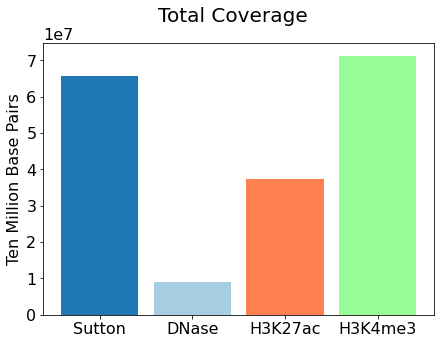

In [41]:
print("Sutton-seq has a total coverage of", original_bed.total_coverage(), "bp")
print("DNase-seq has a total coverage of", dnase_bed.total_coverage(), "bp")
print("ChIP-seq H3K27ac prediction has a total coverage of", h3k27ac_bed.total_coverage(), "bp")
print("ChIP-seq H3K4me3 prediction has a total coverage of", h3k4me3_bed.total_coverage(), "bp")
matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(7, 5))
plt.bar(np.array([0, 0.3, 0.6, 0.9]), 
        np.array([original_bed.total_coverage(), dnase_bed.total_coverage(), 
                  h3k27ac_bed.total_coverage(), h3k4me3_bed.total_coverage()]), 
        width = 0.25,
        align='center',
        color = ["#1F78B4", "#A6CEE3", "#FF7F50", "#98FB98"])
plt.xticks(np.array([0, 0.3, 0.6, 0.9]), np.array(["Sutton", "DNase", "H3K27ac", "H3K4me3"]))
fig.suptitle('Total Coverage', fontsize=20)
plt.ylabel('Ten Million Base Pairs', fontsize=16)


a total of 224694 tss snps
Sutton-seq contains  52475  tss overlaps
DNase-seq contains  22804  tss overlaps
ChIP-seq H3K27ac contains  39644  tss overlaps
ChIP-seq H3K4me3 contains  88387  tss overlaps


Text(0, 0.5, 'Count')

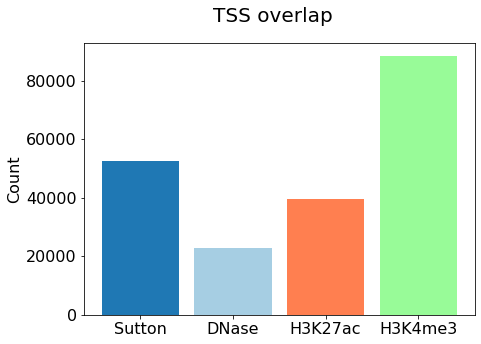

In [42]:
#compare tss overlap
tss_snps = pybedtools.BedTool("/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/refTSS_v3.1_human_coordinate.hg38.bed")
print("a total of", tss_snps.count(), "tss snps")
print("Sutton-seq contains ", original_bed.intersect(tss_snps).count(), " tss overlaps")
print("DNase-seq contains ", dnase_bed.intersect(tss_snps).count(), " tss overlaps")
print("ChIP-seq H3K27ac contains ", h3k27ac_bed.intersect(tss_snps).count(), " tss overlaps")
print("ChIP-seq H3K4me3 contains ", h3k4me3_bed.intersect(tss_snps).count(), " tss overlaps")


fig = plt.figure(figsize=(7, 5))
plt.bar(np.array([0, 0.3, 0.6, 0.9]), 
        np.array([original_bed.intersect(tss_snps).count(), 
                  dnase_bed.intersect(tss_snps).count(),
                  h3k27ac_bed.intersect(tss_snps).count(),
                  h3k4me3_bed.intersect(tss_snps).count()]), 
        width = 0.25,
        color = ["#1F78B4", "#A6CEE3", "#FF7F50", "#98FB98"])
plt.xticks(np.array([0, 0.3, 0.6, 0.9]), np.array(["Sutton", "DNase", "H3K27ac", "H3K4me3"]))
fig.suptitle('TSS overlap', fontsize=20)
plt.ylabel('Count', fontsize=16)


In [43]:
phastCons = pyBigWig.open("/gpfs/ysm/scratch60/gerstein/zc264/ChromVar/enhancer-prediction/encode/dev/hg38.phastCons100way.bw")

original_phastCons = [float(phastCons.stats(x.chrom, x.start, x.stop)[0] or 0) for x in original_bed]
dnase_phastCons = [float(phastCons.stats(x.chrom, x.start, x.stop)[0] or 0) for x in dnase_bed]
h3k27ac_phastCons = [float(phastCons.stats(x.chrom, x.start, x.stop)[0] or 0) for x in h3k27ac_bed]
h3k4me3_phastCons = [float(phastCons.stats(x.chrom, x.start, x.stop)[0] or 0) for x in h3k4me3_bed]

original_phastCons = np.nan_to_num(np.array(original_phastCons))
dnase_phastCons = np.nan_to_num(np.array(dnase_phastCons))
h3k27ac_phastCons = np.nan_to_num(np.array(h3k27ac_phastCons))
h3k4me3_phastCons = np.nan_to_num(np.array(h3k4me3_phastCons))

print("Sutton-seq phastCons score is", np.median(original_phastCons))
print("DNase-seq phastCons score is", np.median(dnase_phastCons))
print("ChIP-seq H3K27ac phastCons score is", np.median(h3k27ac_phastCons))
print("ChIP-seq H3K4me3 phastCons score is", np.median(h3k4me3_phastCons))

RuntimeError: Invalid interval bounds!

3.50e-216
3.50e-216


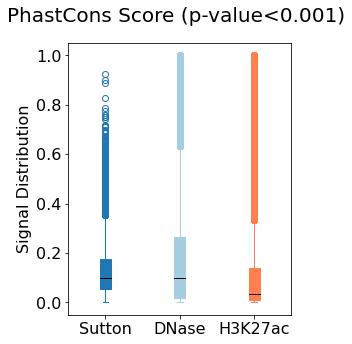

In [35]:
t, p = f_oneway(original_phastCons, dnase_phastCons)
print('{:.2e}'.format(p))

t, p = ttest_ind(original_phastCons, dnase_phastCons)
print('{:.2e}'.format(p))

# fig = plt.figure(figsize=(4, 5))
# box = plt.boxplot(np.array([np.array(original_phastCons), 
#                             np.array(refined_pahstCons)]), 
#                   labels=np.array(["Original", "Refined"]),
#                   boxprops=dict(color="#A6CEE3"),
#                   patch_artist=True, notch=True)
# fig.suptitle('PhastCons Score (p-value=' + str(p) + ")", fontsize=20)
# plt.ylabel('Signal Distribution', fontsize=16)

# colors = ["#A6CEE3", "#1F78B4"]

# plt.show();

fig = plt.figure(figsize=(4, 5))
c = "#1F78B4"
box1 = plt.boxplot(np.array(original_phastCons), positions=[1], patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c))
plt.setp(box1["medians"], color="black")

c2 = "#A6CEE3"
box1 = plt.boxplot(np.array(dnase_phastCons), 
                   positions=[2],
                   patch_artist=True)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box1[item], color=c2)
plt.setp(box1["boxes"], facecolor=c2)
plt.setp(box1["medians"], color="black")
plt.setp(box1["fliers"], markeredgecolor=c2)

c3 = "#FF7F50"
box1 = plt.boxplot(np.array(h3k27ac_phastCons), 
                   positions=[3],
                   patch_artist=True)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(box1[item], color=c3)
plt.setp(box1["boxes"], facecolor=c3)
plt.setp(box1["medians"], color="black")
plt.setp(box1["fliers"], markeredgecolor=c3)


plt.xticks([1,2,3], [1,2,3])
plt.ylabel('Signal Distribution', fontsize=16)
fig.suptitle('PhastCons Score (p-value<0.001)', fontsize=20)
plt.xticks([1, 2, 3], ['Sutton', 'DNase', 'H3K27ac'])
plt.show();

# fig = plt.figure(figsize=(4, 5))
# plt.bar(np.array(["Original", "Refined"]), np.array([np.sum(original_phastCons), np.sum(refined_pahstCons)]))
# fig.suptitle('PhastCons Score', fontsize=20)
# plt.ylabel('Total Signal', fontsize=16)

In [8]:
#hg19 genome lift over
liftOver = "~/liftOver "
hg38_original = args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.merged.bed "
hg38_2_hg19_chain = "~/hg38ToHg19.over.chain "
hg19_lifted = args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.merged.hg19.lifted.bed "
hg19_unlift = args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.merged.hg19.unlift.bed "
os.system(liftOver + hg38_original + hg38_2_hg19_chain + hg19_lifted + hg19_unlift)

liftOver = "~/liftOver "
hg38_original = args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.filtered.bed "
hg38_2_hg19_chain = "~/hg38ToHg19.over.chain "
hg19_lifted = args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.filtered.hg19.lifted.bed "
hg19_unlift = args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.filtered.hg19.unlift.bed "
os.system(liftOver + hg38_original + hg38_2_hg19_chain + hg19_lifted + hg19_unlift)

0

In [9]:
#load in original bed from prediction
original_bed = pybedtools.BedTool(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.merged.hg19.lifted.bed")

#load in bed refined by grad cam
refined_bed = pybedtools.BedTool(args.out_dir + args.cell_name + ".all.prediction_pos_regions.50.filtered.hg19.lifted.bed")

In [10]:
#ASD summary statistics
ASD_snps = pybedtools.BedTool("/ysm-gpfs/pi/gerstein/yc774/project/1kg_phase3/GWAS_catalog/linked_snps/Autism_spectrum_disorder")
print("a total of", ASD_snps.count(), "ASD snps")
print("original prediction has", original_bed.intersect(ASD_snps).count(), "overlap with ASD snps")
print("refined prediction has", refined_bed.intersect(ASD_snps).count(), "overlap with ASD snps")

a total of 4608 ASD snps
original prediction has 122 overlap with ASD snps
refined prediction has 24 overlap with ASD snps


In [11]:
#Bipolar_disorder summary statistics
Bipolar_disorder_snps = pybedtools.BedTool("/ysm-gpfs/pi/gerstein/yc774/project/1kg_phase3/GWAS_catalog/linked_snps/Bipolar_disorder")
print("a total of", Bipolar_disorder_snps.count(), "Bipolar Disorder snps")
print("original prediction has", original_bed.intersect(Bipolar_disorder_snps).count(), "overlap with Bipolar Disorder snps")
print("refined prediction has", refined_bed.intersect(Bipolar_disorder_snps).count(), "overlap with Bipolar Disorder snps")

a total of 30773 Bipolar Disorder snps
original prediction has 898 overlap with Bipolar Disorder snps
refined prediction has 113 overlap with Bipolar Disorder snps


In [12]:
#Schizophrenia summary statistics
Schizophrenia_snps = pybedtools.BedTool("/ysm-gpfs/pi/gerstein/yc774/project/1kg_phase3/GWAS_catalog/linked_snps/Schizophrenia")
print("a total of", Schizophrenia_snps.count(), "Schizophrenia snps")
print("original prediction has", original_bed.intersect(Schizophrenia_snps).count(), "overlap with Schizophrenia snps")
print("refined prediction has", refined_bed.intersect(Schizophrenia_snps).count(), "overlap with Schizophrenia snps")

a total of 128641 Schizophrenia snps
original prediction has 3812 overlap with Schizophrenia snps
refined prediction has 513 overlap with Schizophrenia snps
